CNN신경망

![Alt text](ResNet_Architectures.png)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding
    -in_placnes: in_channels
    -out_placnes: out_channels
    -bias=False: BatchNorm에 bias가 포함되어 있으므로, conv2d에서는 bias=False로 설정
    """
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3, # 여기가 conv3x3 고정
        stride=stride,
        padding=dilation,
        groups=groups, # 이건 뭘까
        bias=False, # BatchNorm에 bias가 포함되어 있으므로, conv2d에서는 bias=False로 설정
        dilation=dilation,
    ) # padding과 dilation이 같은 값으로 되어있는 이유 -> dilation이 1 커질 때 마다 실질적인 conv이 보는 크기(ex커널사이즈)가 5x5, 7x7 영역 등으로 커지기 때문에 동일한 크기의 패딩이 필요

# 차원 맞춰주기 용
def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d: # inputdim -> outputdim // stride 는 크기 줄일때
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False) # conv1x1인데, 보틀넥에서 사용되는 듯


In [3]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()

        # 점선 화살표 부분 맞춰는 코드
        # stride가 1이 아니거나(outplane이 /2로 작아지거나) or in_channel이 out_channel*expansion()
        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [11]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10, init_weights=True):
        super().__init__()

        self.in_channels=64
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        # self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        # x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# def resnet18():
#     return ResNet(BasicBlock, [2,2,2,2])

# def resnet34():
#     return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4 + 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8 + 36, 3])

In [12]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet152().to(device)
x = torch.randn(3, 3, 32, 32).to(device)
output = model(x)
print(output.size())
summary(model, (3, 32, 32), device=device.type)

torch.Size([3, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]           4,096
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              ReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          36,864
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
           Conv2d-10          [-1, 256, 16, 16]          16,384
      BatchNorm2d-11          [-1, 256, 16, 16]             512
           Conv2d-12          [-1, 256, 16, 16]          16,384
      BatchNorm2d-13          [-1, 256, 16, 16]             512
             ReLU-1

In [15]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 30

In [16]:
CIFAR10_train=datasets.CIFAR10("../DataSets/", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
CIFAR10_test=datasets.CIFAR10("../DataSets/", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
train_loader = DataLoader(CIFAR10_train, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
test_loader = DataLoader(CIFAR10_test, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)

In [27]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=resnet152().to(device=device)
loss_func=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=learning_rate)
loss_array = []
accuracy_array = []

In [28]:
def get_accuracy():
  correct = 0
  total = 0
  with torch.no_grad():
      for img, label in test_loader:
          x = img.to(device)
          y_ = label.to(device)

          output = model.forward(x)
          _, output_index = torch.max(output, 1)

          total += label.size(0)
          correct += (output_index == y_).sum().float()

      print("Accuracy of Test Data: {}".format(100*correct/total))
      return correct/total

In [29]:
for i in range(num_epoch):
    print("epoch", i, "is start")
    for j, [img, label] in enumerate(train_loader):
        x = img.to(device)
        y_ = label.to(device)

        optimizer.zero_grad()
        output= model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()

        if j % 30 == 0:
            loss_array.append(loss.cpu().detach().numpy())
            accuracy_array.append(get_accuracy())
    print(loss)

epoch 0 is start
Accuracy of Test Data: 11.934621810913086
Accuracy of Test Data: 16.22121810913086
Accuracy of Test Data: 19.058387756347656
Accuracy of Test Data: 23.5814151763916
Accuracy of Test Data: 26.778371810913086
Accuracy of Test Data: 27.672697067260742
Accuracy of Test Data: 29.6361026763916
Accuracy of Test Data: 31.229440689086914
Accuracy of Test Data: 31.74342155456543
Accuracy of Test Data: 34.54975509643555
tensor(1.8245, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 1 is start
Accuracy of Test Data: 34.436676025390625
Accuracy of Test Data: 36.86266326904297
Accuracy of Test Data: 36.96546173095703
Accuracy of Test Data: 37.87006759643555
Accuracy of Test Data: 39.05221939086914
Accuracy of Test Data: 38.46628189086914
Accuracy of Test Data: 39.85403060913086
Accuracy of Test Data: 38.394325256347656
Accuracy of Test Data: 40.1418571472168
Accuracy of Test Data: 40.152137756347656
tensor(1.6000, device='cuda:0', grad_fn=<NllLossBackward0>)
epoch 2 is start
Accu

KeyboardInterrupt: 

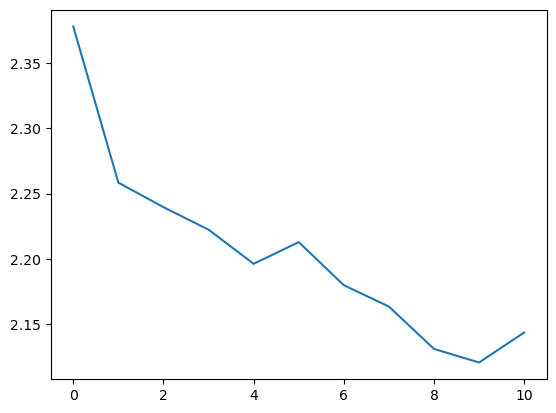

In [20]:
import matplotlib.pyplot as plt
plt.plot(loss_array[:])
plt.show()

In [21]:
correct = 0
total = 0
with torch.no_grad():
    for img, label in test_loader:
        x = img.to(device)
        y_ = label.to(device)

        output = model.forward(x)
        _, output_index = torch.max(output, 1)

        total += label.size(0)
        correct += (output_index == y_).sum().float()

    print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 21.741365432739258
